# First investigation of the system's dynamics

#### Conclusions from first Analysis
-   The heat pump has to be on during every cycle, as the heat losses are too big. Even if the cycle starts at 93°C, the temperature will drop below 85°C, if the heat pump is not turned on. 

-   The optimal power is between approx. 3 and 3.75kW. At 3, the heat pump operation can be continuous. At 3.75, the operation has to be defined in a good way. 

- A thorough COP analysis was done with the information provided in this script and is described thoroughly in the corresponding section (see main.ipynb)

### Different Temperatures 
The following cell shows a gurobi optimization model that shows different "worst-case" scenarios. The idea is the following: The water is heated up to a certain temperature T and the pasta is added. The optimizer looks for the mininmal power (enthalpy per second) that the heatpump has to provide, to keep all the constraints satisfied.

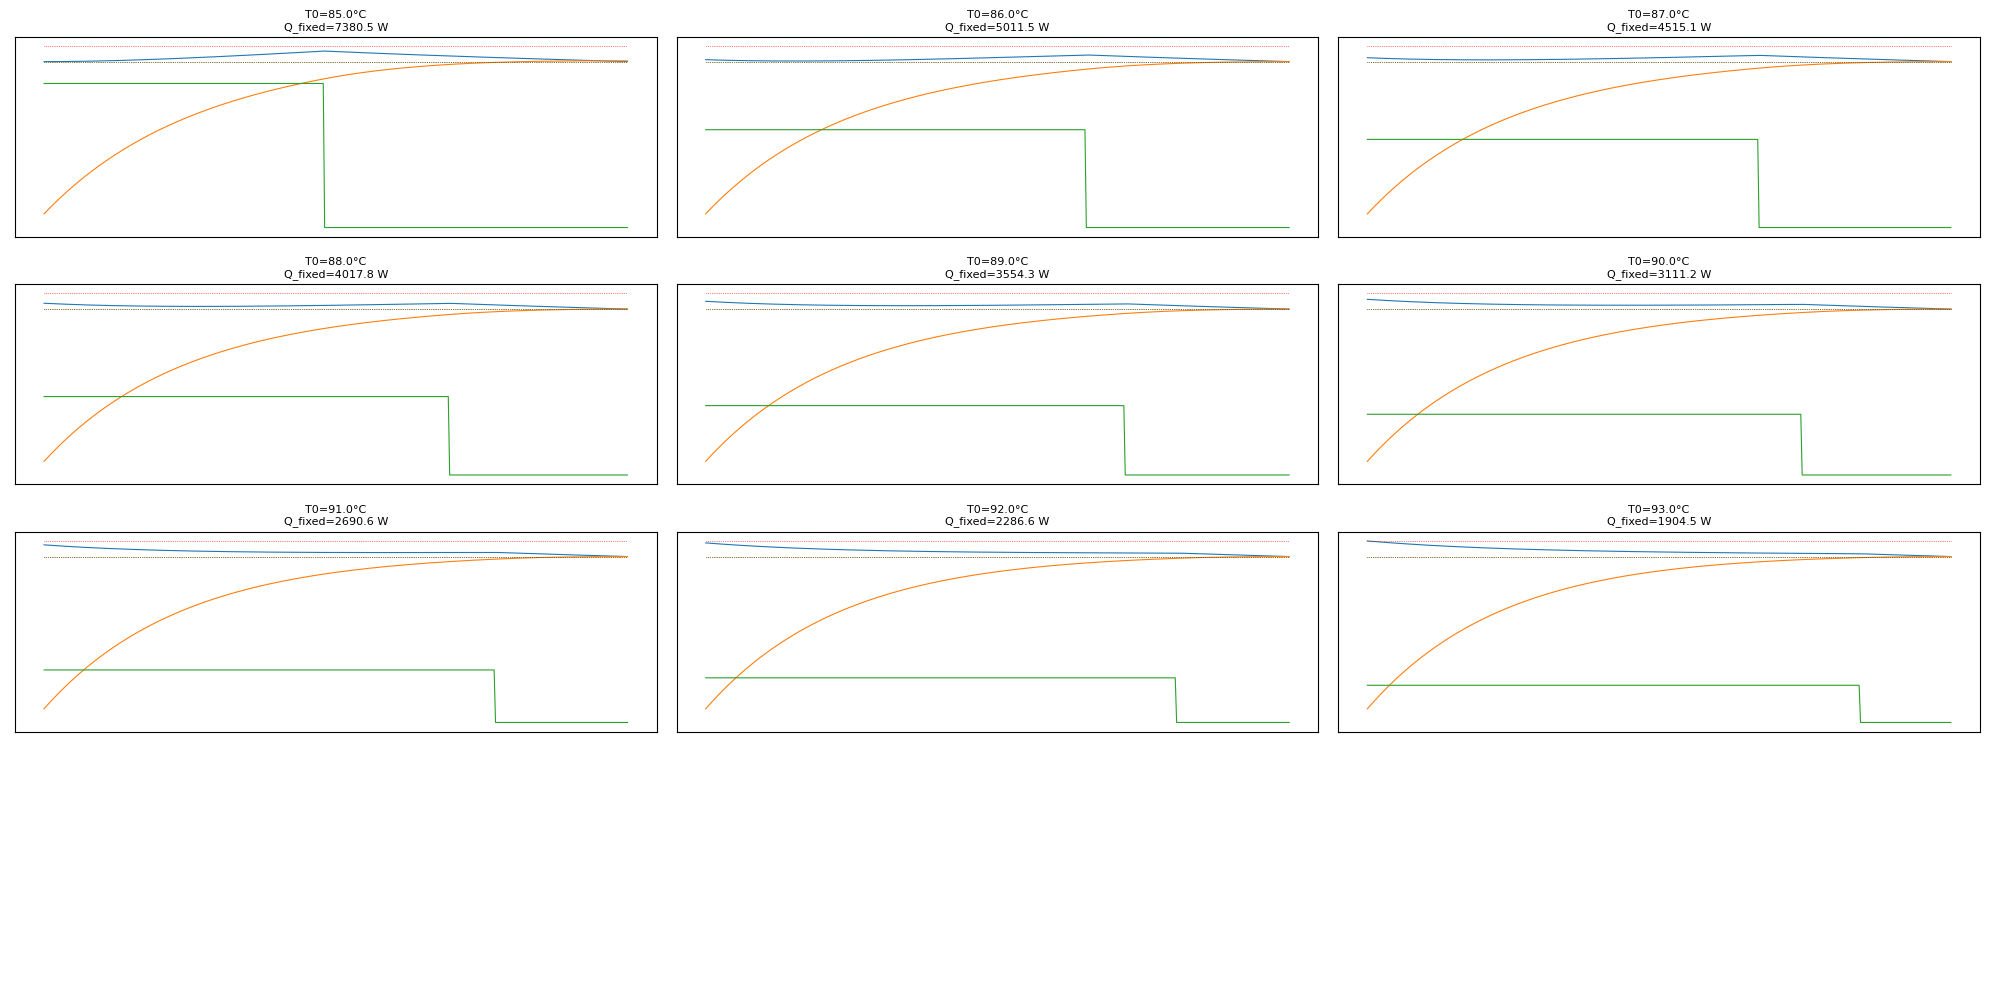

Initial Water Temperature: 85.0 °C, Required Fixed Power: 7380.5 W
Initial Water Temperature: 86.0 °C, Required Fixed Power: 5011.5 W
Initial Water Temperature: 87.0 °C, Required Fixed Power: 4515.1 W
Initial Water Temperature: 88.0 °C, Required Fixed Power: 4017.8 W
Initial Water Temperature: 89.0 °C, Required Fixed Power: 3554.3 W
Initial Water Temperature: 90.0 °C, Required Fixed Power: 3111.2 W
Initial Water Temperature: 91.0 °C, Required Fixed Power: 2690.6 W
Initial Water Temperature: 92.0 °C, Required Fixed Power: 2286.6 W
Initial Water Temperature: 93.0 °C, Required Fixed Power: 1904.5 W


In [5]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt

# Constants
tc_s = 7 * 60        # total cooking time [s]
dt = 1               # time step [s]
n = int(tc_s / dt) + 1
T_env = 20
T_pasta_0 = 7

R_env = 30 / 1000    # [K/W]
R_pasta = 15 / 1000  # [K/W]
c_l = 4.18 * 1000    # [J/kg·K]
c_pasta = 3.5 * 1000 # [J/kg·K]

V_water = (47 - 0.4) * (27 - 0.4) * (20 - 0.2) / 1e6  # m^3
m_water = V_water * 1000
m_pasta = 2

C_water = m_water * c_l
C_pasta = m_pasta * c_pasta

t = np.linspace(0, tc_s, n)
T_water_0_range = np.arange(85.0, 93.1, 1)
Q_fixed_values = []
fig, axs = plt.subplots(4, int(np.ceil(len(T_water_0_range) / 4)), figsize=(20, 10))
axs = axs.flatten()

for idx, T_water_0 in enumerate(T_water_0_range):
    model = gp.Model("HeatPumpCooking")
    model.setParam("OutputFlag", 0)

    Q_fixed = model.addVar(lb=0, ub=10000, name="Q_fixed")
    z = model.addVars(n, vtype=GRB.BINARY, name="z")
    Q = model.addVars(n, lb=0, name="Q")
    delta_on = model.addVars(n, vtype=GRB.BINARY, name="delta_on")
    T_water = model.addVars(n, lb=0, name="T_water")
    T_pasta = model.addVars(n, lb=0, name="T_pasta")

    model.addConstr(T_water[0] == T_water_0)
    model.addConstr(T_pasta[0] == T_pasta_0)

    for t_ in range(1, n):
        model.addConstr(delta_on[t_] >= z[t_] - z[t_-1])
        model.addConstr(delta_on[t_] >= 0)
        model.addConstr(delta_on[t_] <= 1)
        model.addConstr(z[t_] <= z[t_-1])

    model.addConstr(gp.quicksum(delta_on[t_] for t_ in range(1, n)) <= 1)

    for i in range(n):
        model.addConstr(Q[i] == Q_fixed * z[i])
        model.addConstr(T_water[i] >= 85)
        model.addConstr(T_water[i] <= 93)

    for i in range(1, n):
        model.addConstr(
            T_water[i] == T_water[i - 1] + dt * (
                Q[i - 1] - (T_water[i - 1] - T_env) / R_env - (T_water[i - 1] - T_pasta[i - 1]) / R_pasta
            ) / C_water
        )
        model.addConstr(
            T_pasta[i] == T_pasta[i - 1] + dt * (
                (T_water[i - 1] - T_pasta[i - 1]) / R_pasta
            ) / C_pasta
        )

    model.addConstr(T_pasta[n - 1] >= 85)

    model.setObjective(gp.quicksum(Q[i] * dt for i in range(n)) / 1000, GRB.MINIMIZE)
    model.optimize()

    if model.status == GRB.OPTIMAL:
        Q_vals = np.array([Q[i].X for i in range(n)])
        T_water_vals = np.array([T_water[i].X for i in range(n)])
        T_pasta_vals = np.array([T_pasta[i].X for i in range(n)])
        Q_fixed_val = Q_fixed.X
        Q_fixed_values.append(Q_fixed_val)

        ax = axs[idx]
        ax.plot(t / 60, T_water_vals, label="Water Temp (°C)", linewidth=0.8)
        ax.plot(t / 60, T_pasta_vals, label="Pasta Temp (°C)", linewidth=0.8)
        ax.plot(t / 60, Q_vals / 100, label="Q (scaled)", linewidth=0.8)
        ax.hlines([85, 93], 0, tc_s / 60, colors='r', linestyles='dotted', linewidth=0.5)
        ax.hlines([85], 0, tc_s / 60, colors='g', linestyles='dotted', linewidth=0.5)
        ax.set_title(f"T0={T_water_0:.1f}°C\nQ_fixed={Q_fixed_val:.1f} W", fontsize=8)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid(True)
    else:
        Q_fixed_values.append(np.nan)
        axs[idx].set_title(f"T0={T_water_0:.1f}°C\nNo Solution", fontsize=8)
        axs[idx].axis("off")

for ax in axs[len(T_water_0_range):]:
    ax.axis("off")

plt.tight_layout()
plt.show()

#print the initial temperature of the water and the needed fixed power
for i in range(len(T_water_0_range)):
    print(f"Initial Water Temperature: {T_water_0_range[i]:.1f} °C, Required Fixed Power: {Q_fixed_values[i]:.1f} W")

### Same Start and End Temperature for Cycle 
The following cell outputs different possible power configuration where the starting temperature equals the end temperature, making the pasta cooking and cooling off phase/or break phase one "actual cycle" which is reproducible, if the schedule is followed. 

89.7776382863552
89.59373631479176
89.45163492210645
89.26104654817864
89.0
89.5


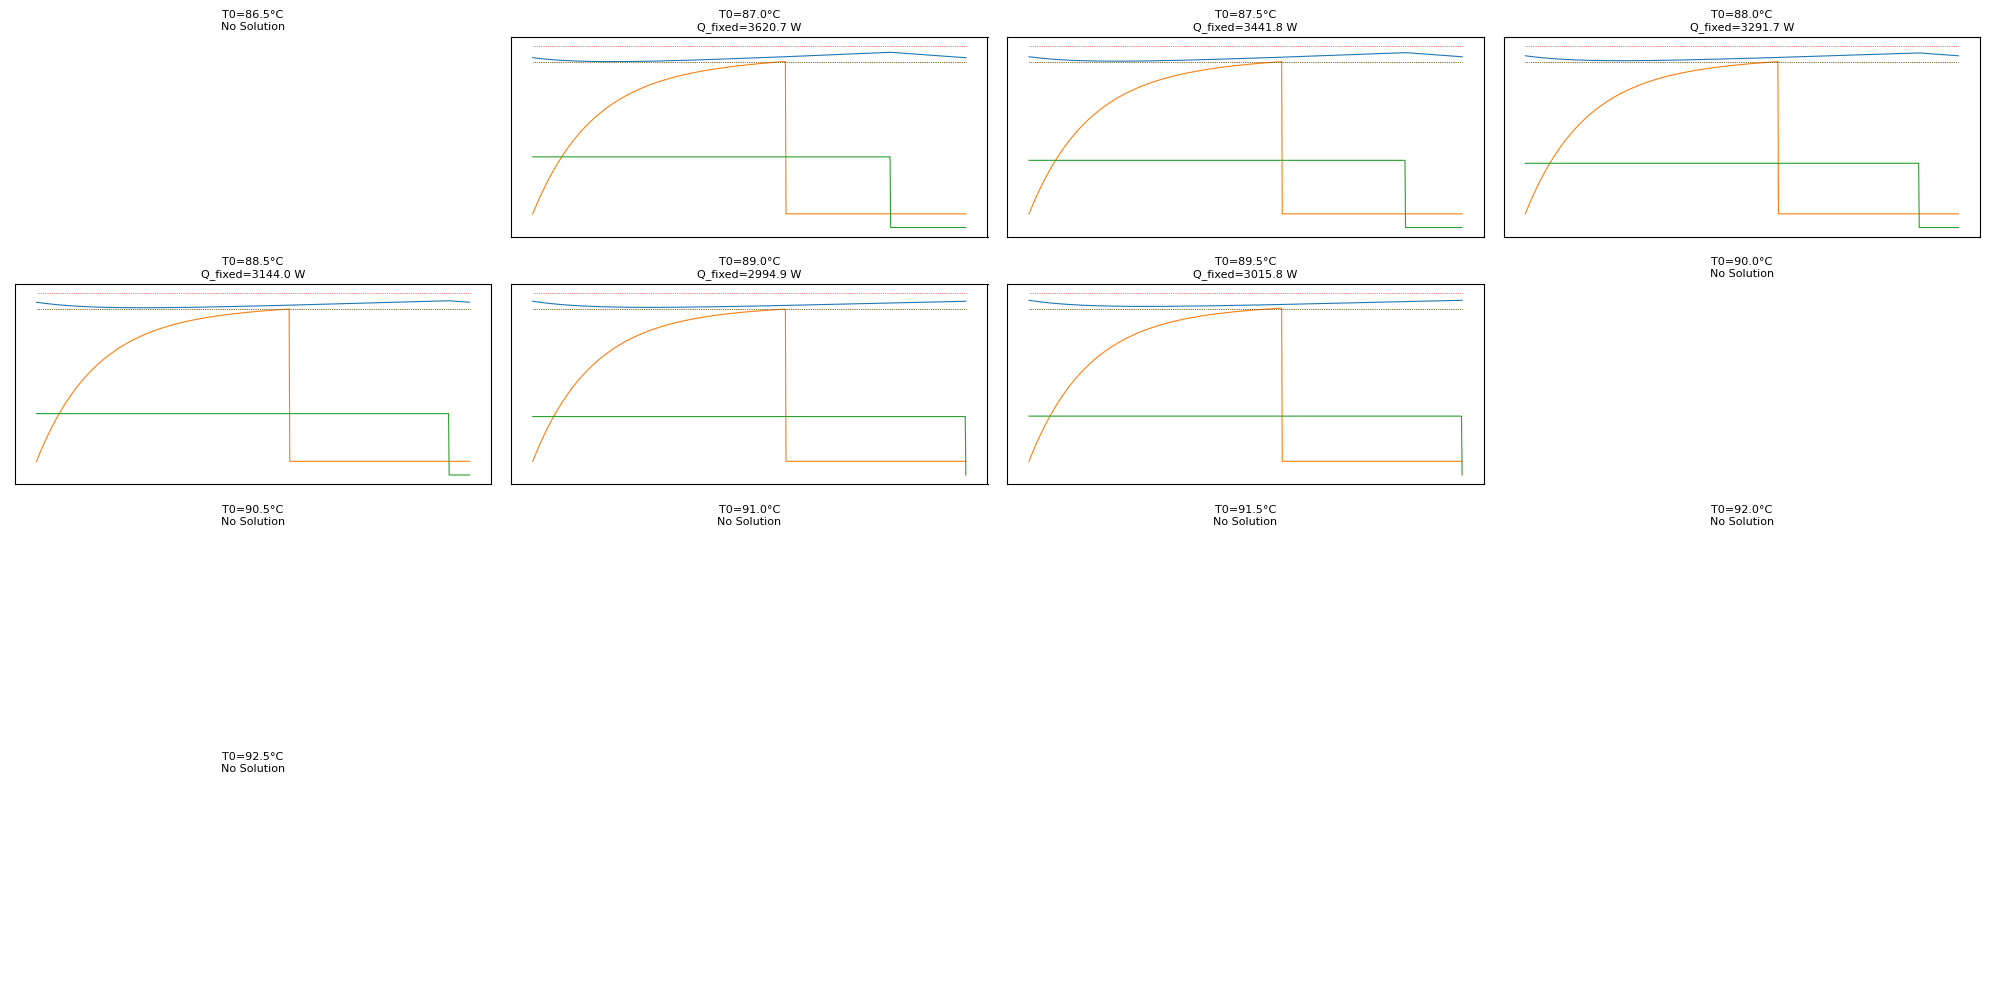

In [24]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt

# Time settings
cook_s = 7 * 60         # Cooking time (with pasta)
cool_s = 5 * 60         # Cooling time (no pasta)
dt = 1
n_cook = int(cook_s / dt)
n_cool = int(cool_s / dt)
n_total = n_cook + n_cool + 1

T_env = 20
T_pasta_0 = 7

# System properties
R_env = 30 / 1000    # [K/W]
R_pasta = 15 / 1000  # [K/W]
c_l = 4.18 * 1000    # [J/kg·K]
c_pasta = 3.5 * 1000 # [J/kg·K]

V_water = (47 - 0.4) * (27 - 0.4) * (20 - 0.2) / 1e6  # m^3
m_water = V_water * 1000
m_pasta = 2

C_water = m_water * c_l
C_pasta = m_pasta * c_pasta

t = np.linspace(0, cook_s + cool_s, n_total)
T_water_0_range = np.arange(86.5, 93, 0.5)
Q_fixed_values = []

fig, axs = plt.subplots(4, int(np.ceil(len(T_water_0_range) / 4)), figsize=(20, 10))
axs = axs.flatten()

for idx, T_water_0 in enumerate(T_water_0_range):
    model = gp.Model("HeatPumpCooking")
    model.setParam("OutputFlag", 0)

    Q_fixed = model.addVar(lb=0, ub=10000, name="Q_fixed")
    z = model.addVars(n_total, vtype=GRB.BINARY, name="z")
    Q = model.addVars(n_total, lb=0, name="Q")
    delta_on = model.addVars(n_total, vtype=GRB.BINARY, name="delta_on")
    T_water = model.addVars(n_total, lb=0, name="T_water")
    T_pasta = model.addVars(n_total, lb=0, name="T_pasta")

    model.addConstr(T_water[0] == T_water_0)
    model.addConstr(T_pasta[0] == T_pasta_0)

    # Heat pump only allowed to switch on once
    for t_ in range(1, n_total):
        model.addConstr(delta_on[t_] >= z[t_] - z[t_-1])
        model.addConstr(z[t_] <= z[t_-1])
        model.addConstr(delta_on[t_] >= 0)
        model.addConstr(delta_on[t_] <= 1)

    model.addConstr(gp.quicksum(delta_on[t_] for t_ in range(1, n_total)) <= 1)

    # Link Q to Q_fixed and z
    for i in range(n_total):
        model.addConstr(Q[i] == Q_fixed * z[i])

    # Temperature dynamics
    for i in range(1, n_total):
        if i <= n_cook:
            # Pasta is in water
            model.addConstr(
                T_water[i] == T_water[i - 1] + dt * (
                    Q[i - 1] - (T_water[i - 1] - T_env) / R_env - (T_water[i - 1] - T_pasta[i - 1]) / R_pasta
                ) / C_water
            )
            model.addConstr(
                T_pasta[i] == T_pasta[i - 1] + dt * (
                    (T_water[i - 1] - T_pasta[i - 1]) / R_pasta
                ) / C_pasta
            )
        else:
            # Pasta removed: only water evolves
            model.addConstr(
                T_water[i] == T_water[i - 1] + dt * (
                    Q[i - 1] - (T_water[i - 1] - T_env) / R_env
                ) / C_water
            )
            model.addConstr(T_pasta[i] == 7)  # Pasta temp freezes

    # Constraints
    for i in range(n_total):
        model.addConstr(T_water[i] >= 85)
        model.addConstr(T_water[i] <= 93)

    model.addConstr(T_pasta[n_cook] >= 85)  # Pasta must be done at 7 min
    model.addConstr(T_pasta[n_cook] <= 85.5)
    model.addConstr(T_water[n_total - 1] == T_water_0)


    model.setObjective(gp.quicksum(Q[i] * dt for i in range(n_total)) / 1000, GRB.MINIMIZE)
    model.optimize()

    if model.status == GRB.OPTIMAL:
        Q_vals = np.array([Q[i].X for i in range(n_total)])
        T_water_vals = np.array([T_water[i].X for i in range(n_total)])
        T_pasta_vals = np.array([T_pasta[i].X for i in range(n_total)])
        Q_fixed_val = Q_fixed.X
        Q_fixed_values.append(Q_fixed_val)

        ax = axs[idx]
        ax.plot(t / 60, T_water_vals, label="Water Temp (°C)", linewidth=0.8)
        print(max(T_water_vals))
        ax.plot(t / 60, T_pasta_vals, label="Pasta Temp (°C)", linewidth=0.8)
        ax.plot(t / 60, Q_vals / 100, label="Q (scaled)", linewidth=0.8)
        ax.hlines([85, 93], 0, t[-1] / 60, colors='r', linestyles='dotted', linewidth=0.5)
        ax.hlines([85], 0, t[-1] / 60, colors='g', linestyles='dotted', linewidth=0.5)
        ax.set_title(f"T0={T_water_0:.1f}°C\nQ_fixed={Q_fixed_val:.1f} W", fontsize=8)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid(True)
    else:
        Q_fixed_values.append(np.nan)
        axs[idx].set_title(f"T0={T_water_0:.1f}°C\nNo Solution", fontsize=8)
        axs[idx].axis("off")

for ax in axs[len(T_water_0_range):]:
    ax.axis("off")

plt.tight_layout()
plt.show()


### Defined Power
The following three cells show the cycle of three nominal power configurations from the upper graph in steps of 0.25kW, which are then to be further analyzed. 

Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[x86] - Darwin 21.6.0 21H1320)

CPU model: Intel(R) Core(TM) i5-6267U CPU @ 2.90GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 6487 rows, 3605 columns and 12787 nonzeros
Model fingerprint: 0x0c03e5c7
Model has 3 quadratic objective terms
Variable types: 2163 continuous, 1442 integer (1442 binary)
Coefficient statistics:
  Matrix range     [1e-05, 3e+03]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-03, 9e+01]
Presolve removed 6255 rows and 3371 columns
Presolve time: 0.25s
Presolved: 232 rows, 234 columns, 727 nonzeros
Presolved model has 3 quadratic objective terms
Variable types: 89 continuous, 145 integer (145 binary)
Found heuristic solution: objective -0.0000000

Root relaxation: cutoff, 7 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current 

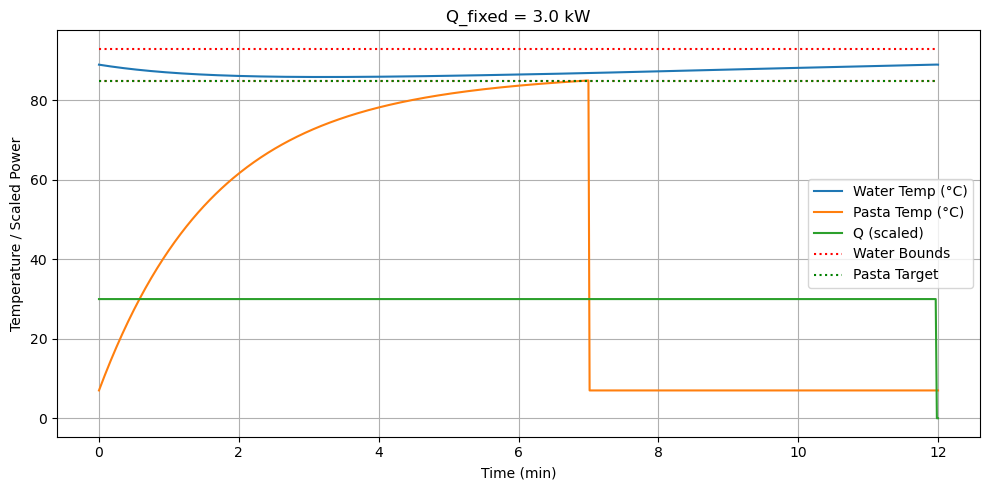

In [14]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt

# Fixierter Wert:
Q_fixed_val = 3000  # Watt

# Time settings
cook_s = 7 * 60
cool_s = 5 * 60
dt = 1
n_cook = int(cook_s / dt)
n_cool = int(cool_s / dt)
n_total = n_cook + n_cool + 1

T_env = 20
T_pasta_0 = 7

# System properties
R_env = 30 / 1000
R_pasta = 15 / 1000
c_l = 4.18 * 1000
c_pasta = 3.5 * 1000

V_water = (47 - 0.4) * (27 - 0.4) * (20 - 0.2) / 1e6
m_water = V_water * 1000
m_pasta = 2

C_water = m_water * c_l
C_pasta = m_pasta * c_pasta

t = np.linspace(0, cook_s + cool_s, n_total)

# --- Gurobi Model ---
model = gp.Model("FixedQ_TempDecision")
model.setParam("OutputFlag", 1)

# Variables
z = model.addVars(n_total, vtype=GRB.BINARY, name="z")
Q = model.addVars(n_total, lb=0, name="Q")
delta_on = model.addVars(n_total, vtype=GRB.BINARY, name="delta_on")
T_water = model.addVars(n_total, lb=0, name="T_water")
T_pasta = model.addVars(n_total, lb=0, name="T_pasta")

# Initial pasta temp
model.addConstr(T_pasta[0] == T_pasta_0)

# Heat pump on only once
for t_ in range(1, n_total):
    model.addConstr(delta_on[t_] >= z[t_] - z[t_-1])
    model.addConstr(z[t_] <= z[t_-1])
    model.addConstr(delta_on[t_] >= 0)
    model.addConstr(delta_on[t_] <= 1)

model.addConstr(gp.quicksum(delta_on[t_] for t_ in range(1, n_total)) <= 1)

# Q is fixed value when on
for i in range(n_total):
    model.addConstr(Q[i] == Q_fixed_val * z[i])

# Dynamics
for i in range(1, n_total):
    if i <= n_cook:
        model.addConstr(
            T_water[i] == T_water[i - 1] + dt * (
                Q[i - 1] - (T_water[i - 1] - T_env) / R_env - (T_water[i - 1] - T_pasta[i - 1]) / R_pasta
            ) / C_water
        )
        model.addConstr(
            T_pasta[i] == T_pasta[i - 1] + dt * (
                (T_water[i - 1] - T_pasta[i - 1]) / R_pasta
            ) / C_pasta
        )
    else:
        model.addConstr(
            T_water[i] == T_water[i - 1] + dt * (
                Q[i - 1] - (T_water[i - 1] - T_env) / R_env
            ) / C_water
        )
        model.addConstr(T_pasta[i] == 7)

# Temperature bounds
for i in range(n_total):
    model.addConstr(T_water[i] >= 85)
    model.addConstr(T_water[i] <= 93)

# Pasta ready
model.addConstr(T_pasta[n_cook] >= 85)
model.addConstr(T_pasta[n_cook] <= 85.1)

# Optional: T_water[0] close to T_water[-1] (could also fix one)
model.setObjective((T_water[n_total - 1] - T_water[0]) * (T_water[n_total - 1] - T_water[0]), GRB.MINIMIZE)

model.optimize()


print("Max water temperature for controlling", max(T_water_vals))

# Extract results
if model.status == GRB.OPTIMAL:
    Q_vals = np.array([Q[i].X for i in range(n_total)])
    T_water_vals = np.array([T_water[i].X for i in range(n_total)])
    T_pasta_vals = np.array([T_pasta[i].X for i in range(n_total)])

    print(f"Optimal T_water[0]: {T_water[0].X:.2f} °C")
    print(f"Optimal T_water[-1]: {T_water[n_total - 1].X:.2f} °C")

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(t / 60, T_water_vals, label="Water Temp (°C)")
    plt.plot(t / 60, T_pasta_vals, label="Pasta Temp (°C)")
    plt.plot(t / 60, Q_vals / 100, label="Q (scaled)")
    plt.hlines([85, 93], 0, t[-1] / 60, colors='r', linestyles='dotted', label="Water Bounds")
    plt.hlines([85], 0, t[-1] / 60, colors='g', linestyles='dotted', label="Pasta Target")
    plt.xlabel("Time (min)")
    plt.ylabel("Temperature / Scaled Power")
    plt.title(f"Q_fixed = {Q_fixed_val / 1000:.1f} kW")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()


Set parameter OutputFlag to value 1


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[x86] - Darwin 21.6.0 21H1320)

CPU model: Intel(R) Core(TM) i5-6267U CPU @ 2.90GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 6487 rows, 3605 columns and 12787 nonzeros
Model fingerprint: 0x2a04e8b8
Model has 3 quadratic objective terms
Variable types: 2163 continuous, 1442 integer (1442 binary)
Coefficient statistics:
  Matrix range     [1e-05, 3e+03]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-03, 9e+01]
Presolve removed 6286 rows and 3402 columns
Presolve time: 0.44s
Presolved: 201 rows, 203 columns, 618 nonzeros
Presolved model has 3 quadratic objective terms
Variable types: 40 continuous, 163 integer (163 binary)
Found heuristic solution: objective 2.9349540

Root relaxation: objective 0.000000e+00, 434 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objec

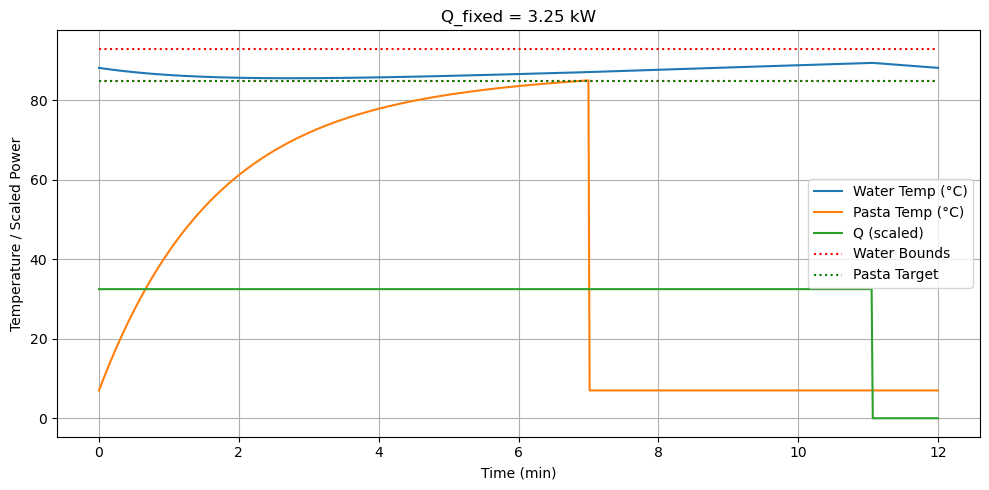

In [15]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt

# Fixierter Wert:
Q_fixed_val = 3250  # Watt

# Time settings
cook_s = 7 * 60
cool_s = 5 * 60
dt = 1
n_cook = int(cook_s / dt)
n_cool = int(cool_s / dt)
n_total = n_cook + n_cool + 1

T_env = 20
T_pasta_0 = 7

# System properties
R_env = 30 / 1000
R_pasta = 15 / 1000
c_l = 4.18 * 1000
c_pasta = 3.5 * 1000

V_water = (47 - 0.4) * (27 - 0.4) * (20 - 0.2) / 1e6
m_water = V_water * 1000
m_pasta = 2

C_water = m_water * c_l
C_pasta = m_pasta * c_pasta

t = np.linspace(0, cook_s + cool_s, n_total)

# --- Gurobi Model ---
model = gp.Model("FixedQ_TempDecision")
model.setParam("OutputFlag", 1)

# Variables
z = model.addVars(n_total, vtype=GRB.BINARY, name="z")
Q = model.addVars(n_total, lb=0, name="Q")
delta_on = model.addVars(n_total, vtype=GRB.BINARY, name="delta_on")
T_water = model.addVars(n_total, lb=0, name="T_water")
T_pasta = model.addVars(n_total, lb=0, name="T_pasta")

# Initial pasta temp
model.addConstr(T_pasta[0] == T_pasta_0)

# Heat pump on only once
for t_ in range(1, n_total):
    model.addConstr(delta_on[t_] >= z[t_] - z[t_-1])
    model.addConstr(z[t_] <= z[t_-1])
    model.addConstr(delta_on[t_] >= 0)
    model.addConstr(delta_on[t_] <= 1)

model.addConstr(gp.quicksum(delta_on[t_] for t_ in range(1, n_total)) <= 1)

# Q is fixed value when on
for i in range(n_total):
    model.addConstr(Q[i] == Q_fixed_val * z[i])

# Dynamics
for i in range(1, n_total):
    if i <= n_cook:
        model.addConstr(
            T_water[i] == T_water[i - 1] + dt * (
                Q[i - 1] - (T_water[i - 1] - T_env) / R_env - (T_water[i - 1] - T_pasta[i - 1]) / R_pasta
            ) / C_water
        )
        model.addConstr(
            T_pasta[i] == T_pasta[i - 1] + dt * (
                (T_water[i - 1] - T_pasta[i - 1]) / R_pasta
            ) / C_pasta
        )
    else:
        model.addConstr(
            T_water[i] == T_water[i - 1] + dt * (
                Q[i - 1] - (T_water[i - 1] - T_env) / R_env
            ) / C_water
        )
        model.addConstr(T_pasta[i] == 7)

# Temperature bounds
for i in range(n_total):
    model.addConstr(T_water[i] >= 85)
    model.addConstr(T_water[i] <= 93)

# Pasta ready
model.addConstr(T_pasta[n_cook] >= 85)
model.addConstr(T_pasta[n_cook] <= 85.1)

# Optional: T_water[0] close to T_water[-1] (could also fix one)
model.setObjective((T_water[n_total - 1] - T_water[0]) * (T_water[n_total - 1] - T_water[0]), GRB.MINIMIZE)

model.optimize()


print("Max water temperature for controlling", max(T_water_vals))


# Extract results
if model.status == GRB.OPTIMAL:
    Q_vals = np.array([Q[i].X for i in range(n_total)])
    T_water_vals = np.array([T_water[i].X for i in range(n_total)])
    T_pasta_vals = np.array([T_pasta[i].X for i in range(n_total)])

    print(f"Optimal T_water[0]: {T_water[0].X:.2f} °C")
    print(f"Optimal T_water[-1]: {T_water[n_total - 1].X:.2f} °C")

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(t / 60, T_water_vals, label="Water Temp (°C)")
    plt.plot(t / 60, T_pasta_vals, label="Pasta Temp (°C)")
    plt.plot(t / 60, Q_vals / 100, label="Q (scaled)")
    plt.hlines([85, 93], 0, t[-1] / 60, colors='r', linestyles='dotted', label="Water Bounds")
    plt.hlines([85], 0, t[-1] / 60, colors='g', linestyles='dotted', label="Pasta Target")
    plt.xlabel("Time (min)")
    plt.ylabel("Temperature / Scaled Power")
    plt.title(f"Q_fixed = {Q_fixed_val / 1000:.2f} kW")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()


Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[x86] - Darwin 21.6.0 21H1320)

CPU model: Intel(R) Core(TM) i5-6267U CPU @ 2.90GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 6487 rows, 3605 columns and 12787 nonzeros
Model fingerprint: 0x8e820b72
Model has 3 quadratic objective terms
Variable types: 2163 continuous, 1442 integer (1442 binary)
Coefficient statistics:
  Matrix range     [1e-05, 4e+03]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-03, 9e+01]
Presolve removed 6292 rows and 3408 columns
Presolve time: 0.45s
Presolved: 195 rows, 197 columns, 591 nonzeros
Presolved model has 3 quadratic objective terms
Variable types: 19 continuous, 178 integer (178 binary)
Found heuristic solution: objective 11.8871882

Root relaxation: objective 0.000000e+00, 406 iterations, 0.01 seconds (0.00 work units)

    Node

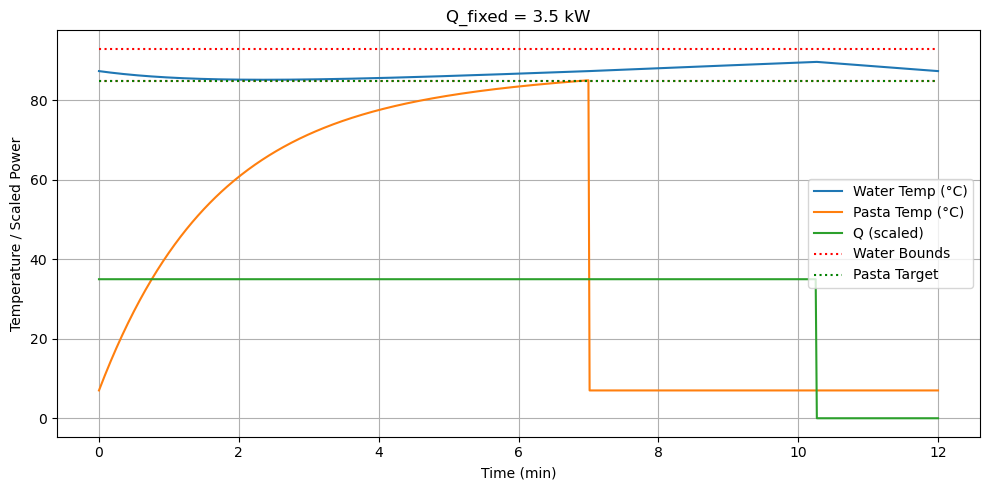

In [18]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt

# Fixierter Wert:
Q_fixed_val = 3500  # Watt

# Time settings
cook_s = 7 * 60
cool_s = 5 * 60
dt = 1
n_cook = int(cook_s / dt)
n_cool = int(cool_s / dt)
n_total = n_cook + n_cool + 1

T_env = 20
T_pasta_0 = 7

# System properties
R_env = 30 / 1000
R_pasta = 15 / 1000
c_l = 4.18 * 1000
c_pasta = 3.5 * 1000

V_water = (47 - 0.4) * (27 - 0.4) * (20 - 0.2) / 1e6
m_water = V_water * 1000
m_pasta = 2

C_water = m_water * c_l
C_pasta = m_pasta * c_pasta

t = np.linspace(0, cook_s + cool_s, n_total)

# --- Gurobi Model ---
model = gp.Model("FixedQ_TempDecision")
model.setParam("OutputFlag", 1)

# Variables
z = model.addVars(n_total, vtype=GRB.BINARY, name="z")
Q = model.addVars(n_total, lb=0, name="Q")
delta_on = model.addVars(n_total, vtype=GRB.BINARY, name="delta_on")
T_water = model.addVars(n_total, lb=0, name="T_water")
T_pasta = model.addVars(n_total, lb=0, name="T_pasta")

# Initial pasta temp
model.addConstr(T_pasta[0] == T_pasta_0)

# Heat pump on only once
for t_ in range(1, n_total):
    model.addConstr(delta_on[t_] >= z[t_] - z[t_-1])
    model.addConstr(z[t_] <= z[t_-1])
    model.addConstr(delta_on[t_] >= 0)
    model.addConstr(delta_on[t_] <= 1)

model.addConstr(gp.quicksum(delta_on[t_] for t_ in range(1, n_total)) <= 1)

# Q is fixed value when on
for i in range(n_total):
    model.addConstr(Q[i] == Q_fixed_val * z[i])

# Dynamics
for i in range(1, n_total):
    if i <= n_cook:
        model.addConstr(
            T_water[i] == T_water[i - 1] + dt * (
                Q[i - 1] - (T_water[i - 1] - T_env) / R_env - (T_water[i - 1] - T_pasta[i - 1]) / R_pasta
            ) / C_water
        )
        model.addConstr(
            T_pasta[i] == T_pasta[i - 1] + dt * (
                (T_water[i - 1] - T_pasta[i - 1]) / R_pasta
            ) / C_pasta
        )
    else:
        model.addConstr(
            T_water[i] == T_water[i - 1] + dt * (
                Q[i - 1] - (T_water[i - 1] - T_env) / R_env
            ) / C_water
        )
        model.addConstr(T_pasta[i] == 7)

# Temperature bounds
for i in range(n_total):
    model.addConstr(T_water[i] >= 85)
    model.addConstr(T_water[i] <= 93)

# Pasta ready
model.addConstr(T_pasta[n_cook] >= 85)
model.addConstr(T_pasta[n_cook] <= 85.1)

# Optional: T_water[0] close to T_water[-1] (could also fix one)
model.setObjective((T_water[n_total - 1] - T_water[0]) * (T_water[n_total - 1] - T_water[0]), GRB.MINIMIZE)

model.optimize()

print("Max water temperature for controlling", max(T_water_vals))

# Extract results
if model.status == GRB.OPTIMAL:
    Q_vals = np.array([Q[i].X for i in range(n_total)])
    T_water_vals = np.array([T_water[i].X for i in range(n_total)])
    T_pasta_vals = np.array([T_pasta[i].X for i in range(n_total)])

    print(f"Optimal T_water[0]: {T_water[0].X:.2f} °C")
    print(f"Optimal T_water[-1]: {T_water[n_total - 1].X:.2f} °C")

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(t / 60, T_water_vals, label="Water Temp (°C)")
    plt.plot(t / 60, T_pasta_vals, label="Pasta Temp (°C)")
    plt.plot(t / 60, Q_vals / 100, label="Q (scaled)")
    plt.hlines([85, 93], 0, t[-1] / 60, colors='r', linestyles='dotted', label="Water Bounds")
    plt.hlines([85], 0, t[-1] / 60, colors='g', linestyles='dotted', label="Pasta Target")
    plt.xlabel("Time (min)")
    plt.ylabel("Temperature / Scaled Power")
    plt.title(f"Q_fixed = {Q_fixed_val / 1000:.1f} kW")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()


In [25]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt

# Fixierter Wert:
Q_fixed_val = 3750  # Watt

# Time settings
cook_s = 7 * 60
cool_s = 5 * 60
dt = 1
n_cook = int(cook_s / dt)
n_cool = int(cool_s / dt)
n_total = n_cook + n_cool + 1

T_env = 20
T_pasta_0 = 7

# System properties
R_env = 30 / 1000
R_pasta = 15 / 1000
c_l = 4.18 * 1000
c_pasta = 3.5 * 1000

V_water = (47 - 0.4) * (27 - 0.4) * (20 - 0.2) / 1e6
m_water = V_water * 1000
m_pasta = 2

C_water = m_water * c_l
C_pasta = m_pasta * c_pasta

t = np.linspace(0, cook_s + cool_s, n_total)

# --- Gurobi Model ---
model = gp.Model("FixedQ_TempDecision")
model.setParam("OutputFlag", 1)

# Variables
z = model.addVars(n_total, vtype=GRB.BINARY, name="z")
Q = model.addVars(n_total, lb=0, name="Q")
delta_on = model.addVars(n_total, vtype=GRB.BINARY, name="delta_on")
T_water = model.addVars(n_total, lb=0, name="T_water")
T_pasta = model.addVars(n_total, lb=0, name="T_pasta")

# Initial pasta temp
model.addConstr(T_pasta[0] == T_pasta_0)

# Heat pump on only once
for t_ in range(1, n_total):
    model.addConstr(delta_on[t_] >= z[t_] - z[t_-1])
    model.addConstr(z[t_] <= z[t_-1])
    model.addConstr(delta_on[t_] >= 0)
    model.addConstr(delta_on[t_] <= 1)

model.addConstr(gp.quicksum(delta_on[t_] for t_ in range(1, n_total)) <= 1)

# Q is fixed value when on
for i in range(n_total):
    model.addConstr(Q[i] == Q_fixed_val * z[i])

# Dynamics
for i in range(1, n_total):
    if i <= n_cook:
        model.addConstr(
            T_water[i] == T_water[i - 1] + dt * (
                Q[i - 1] - (T_water[i - 1] - T_env) / R_env - (T_water[i - 1] - T_pasta[i - 1]) / R_pasta
            ) / C_water
        )
        model.addConstr(
            T_pasta[i] == T_pasta[i - 1] + dt * (
                (T_water[i - 1] - T_pasta[i - 1]) / R_pasta
            ) / C_pasta
        )
    else:
        model.addConstr(
            T_water[i] == T_water[i - 1] + dt * (
                Q[i - 1] - (T_water[i - 1] - T_env) / R_env
            ) / C_water
        )
        model.addConstr(T_pasta[i] == 7)

# Temperature bounds
for i in range(n_total):
    model.addConstr(T_water[i] >= 85)
    model.addConstr(T_water[i] <= 93)

# Pasta ready
model.addConstr(T_pasta[n_cook] >= 85)
model.addConstr(T_pasta[n_cook] <= 85.1)

# Optional: T_water[0] close to T_water[-1] (could also fix one)
model.setObjective((T_water[n_total - 1] - T_water[0]) * (T_water[n_total - 1] - T_water[0]), GRB.MINIMIZE)

model.optimize()

print("Max water temperature for controlling", max(T_water_vals))

# Extract results
if model.status == GRB.OPTIMAL:
    Q_vals = np.array([Q[i].X for i in range(n_total)])
    T_water_vals = np.array([T_water[i].X for i in range(n_total)])
    T_pasta_vals = np.array([T_pasta[i].X for i in range(n_total)])

    print(f"Optimal T_water[0]: {T_water[0].X:.2f} °C")
    print(f"Optimal T_water[-1]: {T_water[n_total - 1].X:.2f} °C")

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(t / 60, T_water_vals, label="Water Temp (°C)")
    plt.plot(t / 60, T_pasta_vals, label="Pasta Temp (°C)")
    plt.plot(t / 60, Q_vals / 100, label="Q (scaled)")
    plt.hlines([85, 93], 0, t[-1] / 60, colors='r', linestyles='dotted', label="Water Bounds")
    plt.hlines([85], 0, t[-1] / 60, colors='g', linestyles='dotted', label="Pasta Target")
    plt.xlabel("Time (min)")
    plt.ylabel("Temperature / Scaled Power")
    plt.title(f"Q_fixed = {Q_fixed_val / 1000:.1f} kW")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()


Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[x86] - Darwin 21.6.0 21H1320)

CPU model: Intel(R) Core(TM) i5-6267U CPU @ 2.90GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 6487 rows, 3605 columns and 12787 nonzeros
Model fingerprint: 0xfbacfd5a
Model has 3 quadratic objective terms
Variable types: 2163 continuous, 1442 integer (1442 binary)
Coefficient statistics:
  Matrix range     [1e-05, 4e+03]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-03, 9e+01]
Presolve removed 5006 rows and 2486 columns
Presolve time: 0.21s

Explored 0 nodes (0 simplex iterations) in 0.33 seconds (0.03 work units)
Thread count was 1 (of 4 available processors)

Solution count 0

Model is infeasible or unbounded
Best objective -, best bound -, gap -
Max water temperature for controlling 89.5


### Possibility of heatpump not being on in every cycle?
The following cells help in the analysis if the heatpump could be turned off during one entire cycle while satisfying all the constraints. If this is possible, their could be additional solutions that were not found yet. (We also looked at the case where the cycle is defined in the flipped way: first 5min of break and then 7min of cooking, these solutions were discarded in the process. This script merely helped us to get a notion of what's going on and what the possibilities are, so we don't miss anything). 

Set parameter OutputFlag to value 1


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[x86] - Darwin 21.6.0 21H1320)

CPU model: Intel(R) Core(TM) i5-6267U CPU @ 2.90GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 12969 rows, 7205 columns and 25569 nonzeros
Model fingerprint: 0x472e9541
Model has 1 quadratic objective term
Variable types: 4323 continuous, 2882 integer (2882 binary)
Coefficient statistics:
  Matrix range     [1e-05, 3e+03]
  Objective range  [2e+02, 2e+02]
  QObjective range [2e+00, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-03, 9e+01]
Presolve removed 12815 rows and 7049 columns
Presolve time: 0.24s
Presolved: 154 rows, 156 columns, 461 nonzeros
Presolved model has 1 quadratic objective terms
Variable types: 3 continuous, 153 integer (153 binary)
Found heuristic solution: objective 55.7498966
Found heuristic solution: objective 9.9747162

Root relaxation: objective 9.790860e+00, 311 iterations, 0.00 seconds (0.00 work units)

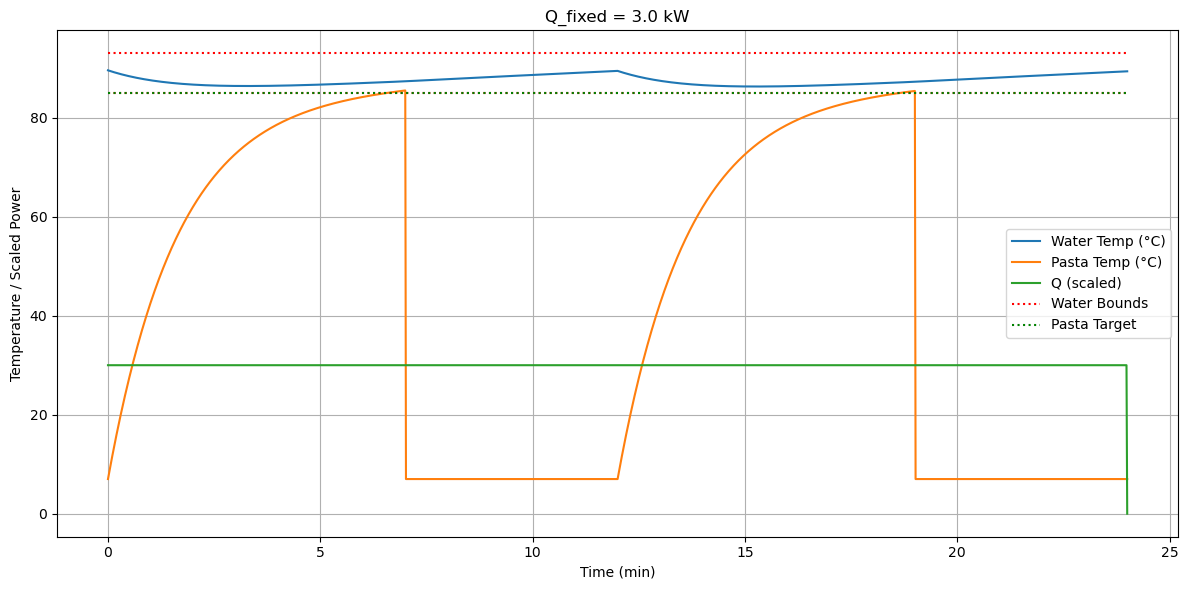

In [26]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt

# Fixed heating power
Q_fixed_val = 3000  # Watt

# Time settings
cook_s = 7 * 60
cool_s = 5 * 60
dt = 1
n_cook = int(cook_s / dt)
n_cool = int(cool_s / dt)
n_total = 2 * (n_cook + n_cool) + 1  # Two cooking and two cooling phases

# Environment and initial temps
T_env = 20
T_pasta_0 = 7

# System properties
R_env = 30 / 1000
R_pasta = 15 / 1000
c_l = 4.18 * 1000
c_pasta = 3.5 * 1000

V_water = (47 - 0.4) * (27 - 0.4) * (20 - 0.2) / 1e6  # m³
m_water = V_water * 1000  # kg (assuming 1 kg/L)
m_pasta = 2  # kg

C_water = m_water * c_l
C_pasta = m_pasta * c_pasta

# Time array
t = np.linspace(0, 2 * (cook_s + cool_s), n_total)

# Gurobi model
model = gp.Model("TwoCookingPhases_OneHeaterOn")
model.setParam("OutputFlag", 1)

# Variables
z = model.addVars(n_total, vtype=GRB.BINARY, name="z")
Q = model.addVars(n_total, lb=0, name="Q")
delta_on = model.addVars(n_total, vtype=GRB.BINARY, name="delta_on")
T_water = model.addVars(n_total, lb=0, name="T_water")
T_pasta = model.addVars(n_total, lb=0, name="T_pasta")

# Initial condition
model.addConstr(T_pasta[0] == T_pasta_0)

# Ensure heater is turned on only once
for t_ in range(1, n_total):
    model.addConstr(delta_on[t_] >= z[t_] - z[t_ - 1])
    model.addConstr(z[t_] <= z[t_ - 1])
    model.addConstr(delta_on[t_] >= 0)
    model.addConstr(delta_on[t_] <= 1)

model.addConstr(gp.quicksum(delta_on[t_] for t_ in range(1, n_total)) <= 1)

# Q only when heater is on
for i in range(n_total):
    model.addConstr(Q[i] == Q_fixed_val * z[i])

# Dynamics
for i in range(1, n_total):
    # Determine if we are in a cooking or cooling phase
    in_first_cook = i <= n_cook
    in_second_cook = (n_cook + n_cool) < i <= (2 * n_cook + n_cool)
    
    if in_first_cook or in_second_cook:
        model.addConstr(
            T_water[i] == T_water[i - 1] + dt * (
                Q[i - 1] - (T_water[i - 1] - T_env) / R_env - (T_water[i - 1] - T_pasta[i - 1]) / R_pasta
            ) / C_water
        )
        model.addConstr(
            T_pasta[i] == T_pasta[i - 1] + dt * (
                (T_water[i - 1] - T_pasta[i - 1]) / R_pasta
            ) / C_pasta
        )
    else:
        # Cooling phase: assume new pasta is added at 7°C
        model.addConstr(
            T_water[i] == T_water[i - 1] + dt * (
                Q[i - 1] - (T_water[i - 1] - T_env) / R_env
            ) / C_water
        )
        model.addConstr(T_pasta[i] == 7)

# Temperature constraints
for i in range(n_total):
    model.addConstr(T_water[i] >= 85)
    model.addConstr(T_water[i] <= 93)

# Pasta must be cooked at the end of both cooking phases
model.addConstr(T_pasta[n_cook] >= 85)
model.addConstr(T_pasta[n_cook] <= 85.5)
model.addConstr(T_pasta[2 * n_cook + n_cool] >= 85)
model.addConstr(T_pasta[2 * n_cook + n_cool] <= 85.5)

# Optional: water temp final close to initial
model.setObjective((T_water[n_total - 1] - T_water_0) ** 2, GRB.MINIMIZE)

# Solve
model.optimize()

# Extract and plot results
if model.status == GRB.OPTIMAL:
    Q_vals = np.array([Q[i].X for i in range(n_total)])
    T_water_vals = np.array([T_water[i].X for i in range(n_total)])
    T_pasta_vals = np.array([T_pasta[i].X for i in range(n_total)])

    print(f"Optimal T_water[0]: {T_water[0].X:.2f} °C")
    print(f"Optimal T_water[-1]: {T_water[n_total - 1].X:.2f} °C")

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(t / 60, T_water_vals, label="Water Temp (°C)")
    plt.plot(t / 60, T_pasta_vals, label="Pasta Temp (°C)")
    plt.plot(t / 60, Q_vals / 100, label="Q (scaled)")
    plt.hlines([85, 93], 0, t[-1] / 60, colors='r', linestyles='dotted', label="Water Bounds")
    plt.hlines([85], 0, t[-1] / 60, colors='g', linestyles='dotted', label="Pasta Target")
    plt.xlabel("Time (min)")
    plt.ylabel("Temperature / Scaled Power")
    plt.title(f"Q_fixed = {Q_fixed_val / 1000:.1f} kW")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

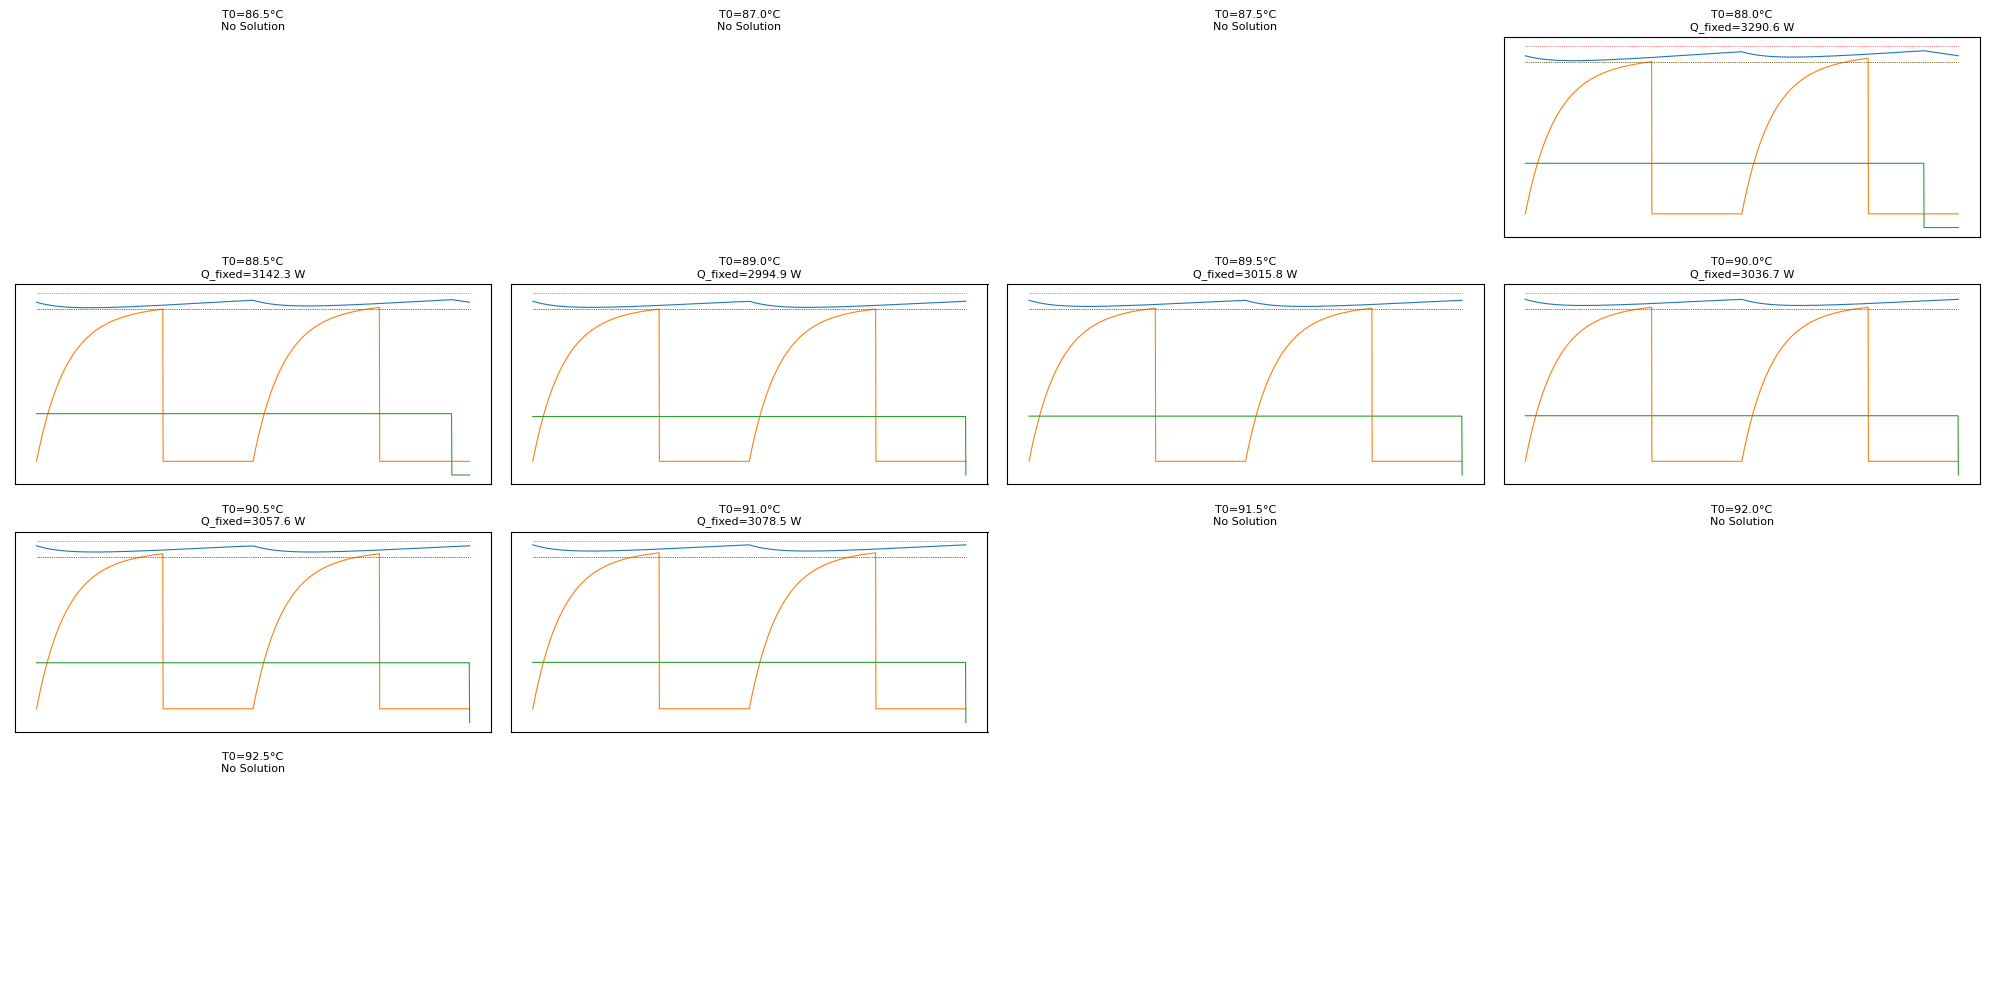

In [23]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt

# Time settings
cook_s = 7 * 60
cool_s = 5 * 60
dt = 1
n_cook = int(cook_s / dt)
n_cool = int(cool_s / dt)
n_total = 2 * (n_cook + n_cool) + 1  # Two cycles

T_env = 20
T_pasta_0 = 7

# System properties
R_env = 30 / 1000
R_pasta = 15 / 1000
c_l = 4.18 * 1000
c_pasta = 3.5 * 1000

V_water = (47 - 0.4) * (27 - 0.4) * (20 - 0.2) / 1e6  # m³
m_water = V_water * 1000
m_pasta = 2

C_water = m_water * c_l
C_pasta = m_pasta * c_pasta

t = np.linspace(0, 2 * (cook_s + cool_s), n_total)
T_water_0_range = np.arange(86.5, 93, 0.5)
Q_fixed_values = []

fig, axs = plt.subplots(4, int(np.ceil(len(T_water_0_range) / 4)), figsize=(20, 10))
axs = axs.flatten()

for idx, T_water_0 in enumerate(T_water_0_range):
    model = gp.Model("TwoCycleHeatPump_OneSwitch")
    model.setParam("OutputFlag", 0)

    Q_fixed = model.addVar(lb=0, ub=10000, name="Q_fixed")
    z = model.addVars(n_total, vtype=GRB.BINARY, name="z")
    Q = model.addVars(n_total, lb=0, name="Q")
    delta_on = model.addVars(n_total, vtype=GRB.BINARY, name="delta_on")
    T_water = model.addVars(n_total, lb=0, name="T_water")
    T_pasta = model.addVars(n_total, lb=0, name="T_pasta")

    # Initial conditions
    model.addConstr(T_water[0] == T_water_0)
    model.addConstr(T_pasta[0] == T_pasta_0)

    # Link heater power to binary state
    for i in range(n_total):
        model.addConstr(Q[i] == Q_fixed * z[i])

    # Heater switching constraints (only 1 switch-on allowed)
    for t_ in range(1, n_total):
        model.addConstr(delta_on[t_] >= z[t_] - z[t_ - 1])
        model.addConstr(z[t_] <= z[t_ - 1])
        model.addConstr(delta_on[t_] >= 0)
        model.addConstr(delta_on[t_] <= 1)

    model.addConstr(gp.quicksum(delta_on[t_] for t_ in range(1, n_total)) <= 1)

    # System dynamics
    for i in range(1, n_total):
        in_first_cook = i <= n_cook
        in_second_cook = (n_cook + n_cool) < i <= (2 * n_cook + n_cool)

        if in_first_cook or in_second_cook:
            model.addConstr(
                T_water[i] == T_water[i - 1] + dt * (
                    Q[i - 1] - (T_water[i - 1] - T_env) / R_env - (T_water[i - 1] - T_pasta[i - 1]) / R_pasta
                ) / C_water
            )
            model.addConstr(
                T_pasta[i] == T_pasta[i - 1] + dt * (
                    (T_water[i - 1] - T_pasta[i - 1]) / R_pasta
                ) / C_pasta
            )
        else:
            model.addConstr(
                T_water[i] == T_water[i - 1] + dt * (
                    Q[i - 1] - (T_water[i - 1] - T_env) / R_env
                ) / C_water
            )
            model.addConstr(T_pasta[i] == 7)  # New pasta inserted

    # Temperature bounds
    for i in range(n_total):
        model.addConstr(T_water[i] >= 85)
        model.addConstr(T_water[i] <= 100)

    # Cooking quality constraints
    model.addConstr(T_pasta[n_cook] >= 85)
    model.addConstr(T_pasta[n_cook] <= 87)
    model.addConstr(T_pasta[2 * n_cook + n_cool] >= 85)
    model.addConstr(T_pasta[2 * n_cook + n_cool] <= 87)

    # Final water temp = initial temp
    model.addConstr(T_water[n_total - 1] == T_water_0)

    # Objective: minimize energy in kJ
    model.setObjective(gp.quicksum(Q[i] * dt for i in range(n_total)) / 1000, GRB.MINIMIZE)

    model.optimize()

    if model.status == GRB.OPTIMAL:
        Q_vals = np.array([Q[i].X for i in range(n_total)])
        T_water_vals = np.array([T_water[i].X for i in range(n_total)])
        T_pasta_vals = np.array([T_pasta[i].X for i in range(n_total)])
        Q_fixed_val = Q_fixed.X
        Q_fixed_values.append(Q_fixed_val)

        ax = axs[idx]
        ax.plot(t / 60, T_water_vals, label="Water Temp (°C)", linewidth=0.8)
        ax.plot(t / 60, T_pasta_vals, label="Pasta Temp (°C)", linewidth=0.8)
        ax.plot(t / 60, Q_vals / 100, label="Q (scaled)", linewidth=0.8)
        ax.hlines([85, 93], 0, t[-1] / 60, colors='r', linestyles='dotted', linewidth=0.5)
        ax.hlines([85], 0, t[-1] / 60, colors='g', linestyles='dotted', linewidth=0.5)
        ax.set_title(f"T0={T_water_0:.1f}°C\nQ_fixed={Q_fixed_val:.1f} W", fontsize=8)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid(True)
    else:
        Q_fixed_values.append(np.nan)
        axs[idx].set_title(f"T0={T_water_0:.1f}°C\nNo Solution", fontsize=8)
        axs[idx].axis("off")

# Turn off unused subplots
for ax in axs[len(T_water_0_range):]:
    ax.axis("off")

plt.tight_layout()
plt.show()